# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

D = np.loadtxt('../data/lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

In [2]:
eps = 1e-12

In [3]:
X = (X - X.mean(axis=0))/(X.std(axis = 0) + eps)
Y = Y.reshape((-1,1))
# X = np.hstack((torch.ones(X.shape[0], 1), X))
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [4]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_features):
        super(LinearModel,self).__init__()
        self.fc = torch.nn.Linear(in_features, 1, bias=True)
        
    def forward(self,x):
        x = self.fc(x)
        return x

In [5]:
def train_model(model, criterion, optimizer, 
                X_train, y_train, 
                X_val=None, y_val=None, 
                batch_size = 16, epochs = 500, verbose = True):
    
    history, val_history = [], []
    for epoch in range(1, epochs + 1):
        fraction = X_train.shape[0] // batch_size
        batch_range = range(fraction)
        
        for i in batch_range:
            x_batch = X_train[i * batch_size: (i + 1) * batch_size]
            y_batch = y_train[i * batch_size: (i + 1) * batch_size]
            
            optimizer.zero_grad()
            predictions = model(x_batch)
            
            loss = criterion(y_batch, predictions)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
        with torch.no_grad():
            history.append(loss.item())
            if (X_val is not None) or (y_val is not None):
                val_predictions = model(X_val)
                val_history.append(criterion(val_predictions, y_val).item())
                
        if verbose:
            output = f'epoch {epoch}: {history[-1]}' if (X_val is None) or (y_val is None) else f'epoch {epoch}: {loss.item()}; val loss: {val_history[-1]}'
            print(output)
            
    return history, val_history

### 1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования.

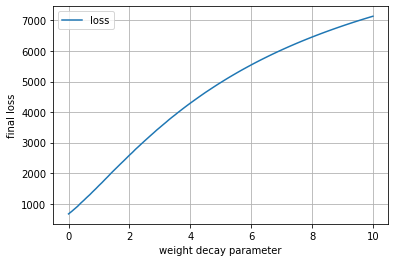

In [6]:
param_range = np.arange(0.0, 10.1, 0.1)
loss_list = []

for alpha in param_range:
    model = LinearModel(X.shape[1])
    mse_loss = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4, weight_decay= alpha)

    history, val_history = train_model(model, mse_loss, optimizer, X, Y,
        epochs = 100,
        batch_size = 16,
        verbose = False)
    model.eval()
    prediction = model(X)
    loss = mse_loss(prediction, Y)
    loss_list.append(loss.item())

plt.plot(param_range, loss_list, label = 'loss')
plt.xlabel("weight decay parameter")
plt.ylabel("final loss")
plt.legend() 
plt.grid()
plt.show()

### 2. Подготовьте исходные данные для 5 fold CV.

In [7]:
def k_fold_training(X, y, k, epochs, lr, weight_decay_param, batch_size = 16, verbose = True):
    num_val_samples = len(X) // k
    
    models = []
    history_list = []
    train_scores = []
    val_scores = []
    
    for i in range(k):
        if verbose:
            print('processing fold #', i + 1)
        val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = Y[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = torch.Tensor(np.concatenate([X[:i * num_val_samples],
                                                          X[(i + 1) * num_val_samples:]],
                                                         axis=0))
        partial_train_targets = torch.Tensor(np.concatenate([y[:i * num_val_samples],
                                                             y[(i + 1) * num_val_samples:]], axis=0))
        model = LinearModel(X.shape[1])
        criterion = torch.nn.MSELoss() 
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay = weight_decay_param)
        
        if verbose:
            print(f'Training {i+1} model')
        history = train_model(model, criterion, optimizer, partial_train_data, partial_train_targets, val_data, val_targets,
                               batch_size = batch_size,
                              epochs = epochs,
                             verbose = False)
        
        with torch.no_grad():
            val_score = criterion(model(val_data), val_targets)
            train_score = criterion(model(partial_train_data), partial_train_targets)
            
        if verbose:
            print(f'val_score: {val_score}')
        
        models.append(model)
        train_scores.append(train_score)
        val_scores.append(val_score)        
        history_list.append(history)
    
    return {'models': models, 'history': history_list, 'train_scores': train_scores, 'val_scores': val_scores}
    

In [8]:
info = k_fold_training(X,Y, 5, 50, 0.1, weight_decay_param=0.1)

processing fold # 1
Training 1 model
val_score: 111.44230651855469
processing fold # 2
Training 2 model
val_score: 112.59626007080078
processing fold # 3
Training 3 model
val_score: 135.98614501953125
processing fold # 4
Training 4 model
val_score: 123.69572448730469
processing fold # 5
Training 5 model
val_score: 135.38833618164062


### 3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.

In [9]:
def random_search(X, y , steps, lr, weight_decay_param, verbose = True, epochs = 100,batch_size = 16):
    mean_scores = []
    params_list = []
    for i in range(1, steps+1):
        random_lr = np.random.uniform(*lr)
        random_weigh_decay = np.random.uniform(*weight_decay_param)
        params = {'lr': random_lr, 'weight_decay': random_weigh_decay}
        
        if verbose:
            print(f'{i}) random_lr: {random_lr}; random_weight_decay: {random_weigh_decay}')
        
        info = k_fold_training(X, y, 5, epochs, random_lr, random_weigh_decay, batch_size = batch_size, verbose = False)
        mean_score = np.array(info['val_scores']).mean()
        
        if verbose:
            print(f'mean score: {mean_score}\n')
        mean_scores.append(mean_score)
        params_list.append(params)
    
    min_index = np.array(mean_scores).argmin()
    if verbose:
        print(f'optimal params: {params_list[min_index]}; mean score: {mean_scores[min_index]}')
    return params_list[min_index]
        

In [11]:
params_list = random_search(X, Y, 10, [1e-5, 1e-1], [0.0, 1.0])

1) random_lr: 0.05100182745195419; random_weight_decay: 0.7809326194117424
mean score: 723.5982055664062

2) random_lr: 0.05322947772364068; random_weight_decay: 0.42220820207014464
mean score: 336.5386657714844

3) random_lr: 0.04372497892336399; random_weight_decay: 0.8692579893478263
mean score: 821.38427734375

4) random_lr: 0.07609329909948494; random_weight_decay: 0.6237185292018089
mean score: 571.5706176757812

5) random_lr: 0.08102274443307456; random_weight_decay: 0.24690638131464027
mean score: 201.63735961914062

6) random_lr: 0.04672512367589341; random_weight_decay: 0.8560074609675585
mean score: 808.5921020507812

7) random_lr: 0.05621781850134052; random_weight_decay: 0.8009621389427481
mean score: 754.7197875976562

8) random_lr: 0.04916949720943535; random_weight_decay: 0.5098473514399121
mean score: 420.1475524902344

9) random_lr: 0.039339700005774886; random_weight_decay: 0.8930153484511701
mean score: 846.3201293945312

10) random_lr: 0.02371164133102424; random_w

### 4. Постройте валидационную кривую. 
### 5. Постройте кривую обучения.

In [12]:
model = LinearModel(X.shape[1])
mse_loss = torch.nn.MSELoss(reduction='mean')
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-4,
#                             momentum = 0.97,
#                             nesterov=True,
#                             weight_decay=1)
optimizer = torch.optim.SGD(model.parameters(), **params_list)

history, val_history = train_model(model, mse_loss, optimizer, X[200:], Y[200:],
        X[:200], Y[:200],
        epochs = 10,
        batch_size = 16,
        verbose = True)

epoch 1: 131.4470977783203; val loss: 273.8025817871094
epoch 2: 77.14971160888672; val loss: 171.6434783935547
epoch 3: 74.6630630493164; val loss: 166.36749267578125
epoch 4: 74.46469116210938; val loss: 166.0
epoch 5: 74.43684387207031; val loss: 165.9660186767578
epoch 6: 74.42491912841797; val loss: 165.9574737548828
epoch 7: 74.41664123535156; val loss: 165.95242309570312
epoch 8: 74.41029357910156; val loss: 165.94830322265625
epoch 9: 74.40544128417969; val loss: 165.94532775878906
epoch 10: 74.40182495117188; val loss: 165.94322204589844


165.94322204589844


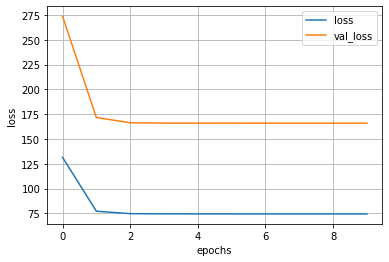

In [13]:
print(val_history[-1])
plt.plot(range(len(history)), history, label = 'loss')
plt.plot(range(len(val_history)), val_history, label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend() 
plt.grid()
plt.show()